In [3]:
import gzip
import numpy
import random
from sklearn.svm import SVR

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

In [330]:
allHelpful = []
for l in readGz("train.json.gz"):
    user, item = l['reviewerID'], l['itemID']
    categoryID = l['categoryID']
    rating = l['rating']
    allHelpful.append([l['helpful'], categoryID, len(l['reviewText'].split()), rating])

In [331]:
fold = 5
allHelpful_cache = allHelpful
#random.shuffle(allHelpful)
train_Helpful = allHelpful[:200000]
valid_Helpful = allHelpful[160000:]

category = [[],[],[],[],[]]

for l in train_Helpful:
    category[l[1]].append(l[3])
    
category_ave = []
for l in category:
    category_ave.append(numpy.mean(l))

category_ave

[4.1850434905593668,
 4.3434763998599166,
 4.3508098891730604,
 4.4418238993710695,
 4.4189925119128661]

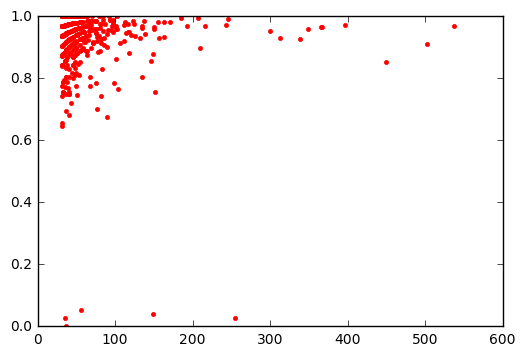

In [21]:
plot_y = []
plot_x = []
for l in train_Helpful:
    if (l[0]['outOf'] >30)  and (l[0]['outOf']>0):
        plot_y.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        plot_x.append(l[0]['outOf'])
import matplotlib.pyplot as plt
plt.plot(plot_x, plot_y, 'r.')
plt.show()

In [199]:
X_train = []
y_train = []
for l in train_Helpful:
    if l[0]['outOf'] >= 10:
        y_train.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        X_train.append([1, l[2], l[3] * 1.0 / category_ave[l[1]] - 1, l[0]['outOf']])

In [200]:
theta, residuals, rank, s = numpy.linalg.lstsq(X_train, y_train)

print "Fitted parameter: " + str(theta)

X_valid = [[1, l[2], l[3] * 1.0 / category_ave[l[1]] - 1, l[0]['outOf']] for l in valid_Helpful]
y_valid = [l[0] for l in valid_Helpful]
y_valid_predict = numpy.dot(X_valid, theta)
MAE_valid3 = sum(abs(a * b['outOf'] - b['nHelpful']) for (a, b) in zip(y_valid_predict, y_valid)) * 1.0 / len(y_valid)
X_train1 = [[1, l[2], l[3] * 1.0 / category_ave[l[1]] - 1, l[0]['outOf']] for l in train_Helpful]
y_train1 = [l[0] for l in train_Helpful]
y_train1_predict = numpy.dot(X_train1, theta)
MAE_train1 = sum(abs(a * b['outOf'] - b['nHelpful']) for (a, b) in zip(y_train1_predict, y_train1)) * 1.0 / len(y_train1)
print "MAE of validate set is: " + str(MAE_valid3)
print "MAE of training set is: " + str(MAE_train1)

Fitted parameter: [  8.90722541e-01   2.37177738e-05   1.71502039e-01   2.42227416e-04]
MAE of validate set is: 0.183917449458
MAE of training set is: 0.195027130912


In [201]:
# Problem 4
predictions = open("predictions_Helpful.csv", 'w')
predictions.write("userID-itemID-outOf,prediction\n")
for l in readGz("test_Helpful.json.gz"):
    user, item = l['reviewerID'],l['itemID']
    predict = numpy.round(l['helpful']['outOf'] * numpy.dot([1, l['reviewText'].count(' ') + 1, l['rating'] * 1.0 / category_ave[l['categoryID']] - 1, l['helpful']['outOf']], theta))
    predictions.write(user + '-' + item + '-' + str(l['helpful']['outOf']) + ',' + str(predict) + '\n')
predictions.close()

# SVM

In [164]:
# SVM
X_train = []
y_train = []
for l in train_Helpful:
    if l[0]['outOf'] >= 10:
        y_train.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        X_train.append([l[2], l[3] - category_ave[l[1]], l[0]['outOf']])

X_valid = [[l[2], l[3] - category_ave[l[1]], l[0]['outOf']] for l in valid_Helpful]
y_valid = [l[0]['nHelpful'] for l in valid_Helpful]

In [197]:
svr_rbf = SVR(kernel='rbf', C=1e-4, gamma=0.001)
model = svr_rbf.fit(X_train, y_train)

In [198]:
predict_valid = model.predict(X_valid) * [l[0]['outOf'] for l in valid_Helpful]
sum(abs(a - round(b)) for (a, b) in zip(y_valid, predict_valid)) * 1.0 / len(y_valid)

0.17995

In [193]:
X_predict = [[l['reviewText'].count(' ') + 1, l['rating'] - category_ave[l['categoryID']], l['helpful']['outOf']] for l in readGz("test_Helpful.json.gz")]
ratio = model.predict(X_predict)
predict_all = numpy.round(ratio * [l['helpful']['outOf'] for l in readGz("test_Helpful.json.gz")])

In [194]:
predictions = open("predictions_Helpful.csv", 'w')
predictions.write("userID-itemID-outOf,prediction\n")
i = 0
for l in readGz("test_Helpful.json.gz"):
    user, item = l['reviewerID'],l['itemID']
    predict = predict_all[i]
    i += 1
    predictions.write(user + '-' + item + '-' + str(l['helpful']['outOf']) + ',' + str(predict) + '\n')
predictions.close()

# KNN

In [332]:
X_train = []
y_train = []
for l in train_Helpful:
    if l[0]['outOf'] >= 4 and l[0]['outOf'] - l[0]['nHelpful'] <= 16:
        y_train.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        X_train.append([l[2], l[3] - category_ave[l[1]], l[0]['outOf']])

X_valid = [[l[2], l[3] - category_ave[l[1]], l[0]['outOf']] for l in valid_Helpful]
y_valid = [l[0]['nHelpful'] for l in valid_Helpful]

In [340]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=23)
neigh.fit(X_train, y_train) 
rate = neigh.predict(X_valid) 
#rate = (rate - [0.05] * len(rate)) / 0.91 * 1.0
rate[rate<0] = 0
rate[rate > 1] = 1
predict_valid = rate * [l[0]['outOf'] for l in valid_Helpful]
sum(abs(a - round(b)) for (a, b) in zip(y_valid, predict_valid)) * 1.0 / len(y_valid)

0.17035

In [140]:
predict_valid

array([ 0.68681319,  0.        ,  0.        , ...,  0.        ,
        0.85164835,  0.        ])

In [345]:
X_predict = [[len(l['reviewText'].split()), l['rating'] - category_ave[l['categoryID']], l['helpful']['outOf']] for l in readGz("test_Helpful.json.gz")] #

In [346]:
ratio = neigh.predict(X_predict)
#ratio = (ratio - [0.05] * len(ratio)) / 0.91 * 1.0
ratio[ratio < 0] = 0
ratio[ratio > 1] = 1

In [350]:
ratio

array([ 0.76086957,  0.80434783,  0.84782609, ...,  0.93478261,
        0.80434783,  0.83695652])

In [351]:
predict_all = numpy.round(ratio * [l['helpful']['outOf'] for l in readGz("test_Helpful.json.gz")])
predictions = open("predictions_Helpful.csv", 'w')
predictions.write("userID-itemID-outOf,prediction\n")
i = 0
for l in readGz("test_Helpful.json.gz"):
    user, item = l['reviewerID'],l['itemID']
    predict = predict_all[i]
    i += 1
    predictions.write(user + '-' + item + '-' + str(l['helpful']['outOf']) + ',' + str(predict) + '\n')
predictions.close()

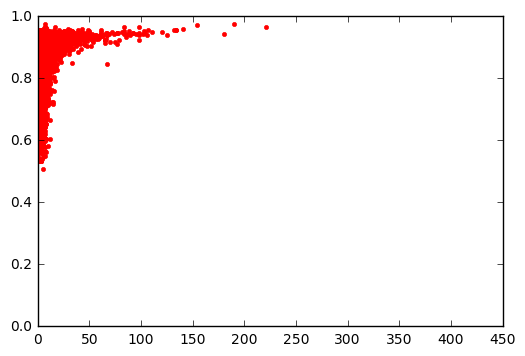

In [338]:
plot_x = [l[0]['outOf'] for l in valid_Helpful]
ratio_try = neigh.predict(X_valid)
#ratio_test = (ratio_try - [0.55] * len(ratio_try)) / 0.4 * 1
ratio_test = ratio_try
ratio_test[ratio_test < 0] = 0
ratio_test[ratio_test > 1] = 1
import matplotlib.pyplot as plt
plt.plot(plot_x, ratio_test, 'r.')
plt.axis([0, 450, 0, 1])
plt.show()

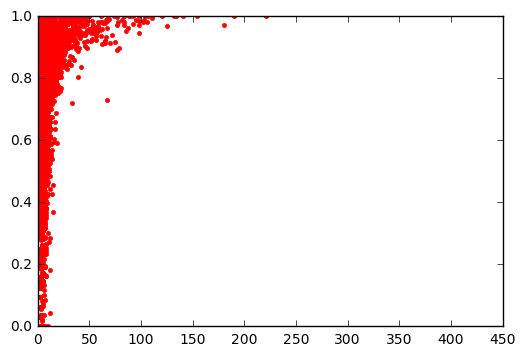

In [230]:
plot_x = [l[0]['outOf'] for l in valid_Helpful]
ratio_try = neigh.predict(X_valid)
ratio_test = (ratio_try - [0.55] * len(ratio_try)) / 0.4 * 1
ratio_test[ratio_test < 0] = 0
ratio_test[ratio_test > 1] = 1
import matplotlib.pyplot as plt
plt.plot(plot_x, ratio_test, 'r.')
plt.axis([0, 450, 0, 1])
plt.show()

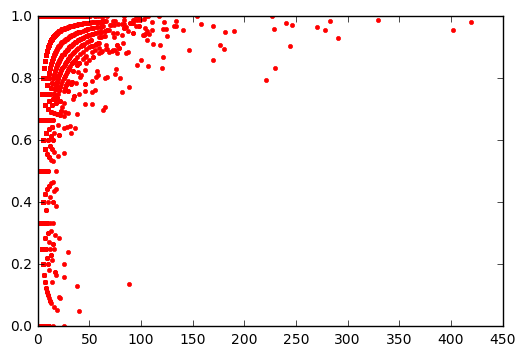

In [86]:
plot_y = []
plot_x = []
for l in valid_Helpful:
    if l[0]['outOf']>0:
        plot_y.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        plot_x.append(l[0]['outOf'])
import matplotlib.pyplot as plt
plt.plot(plot_x, plot_y, 'r.')
plt.axis([0, 450, 0, 1])
plt.show()

In [ ]:
# Problem 1
averageRate = sum([x['nHelpful'] for x in train_Helpful]) * 1.0 / sum([x['outOf'] for x in train_Helpful])
print "alpha = " + str(averageRate)

# Problem 2
diff = 0
for r in valid_Helpful:
    diff += abs(r['outOf'] * averageRate - r['nHelpful'])
MAE = diff * 1.0 / len(valid_Helpful)
print "MAE = " + str(MAE)

# Problem 3
allHelpful = []
for l in readGz("train.json.gz"):
    user, item = l['reviewerID'], l['itemID']
    allHelpful.append([l['helpful'], l['reviewText'].count(' ') + 1, l['rating']])

train_Helpful = allHelpful[:100000]
valid_Helpful = allHelpful[100000:]

X_train = []
y_train = []
for l in train_Helpful:
    if l[0]['outOf'] != 0:
        y_train.append(l[0]['nHelpful'] * 1.0 / l[0]['outOf'])
        X_train.append([1, l[1], l[2]])

theta, residuals, rank, s = numpy.linalg.lstsq(X_train, y_train)

print "Fitted parameter: " + str(theta)

X_valid = [[1, l[1], l[2]] for l in valid_Helpful]
y_valid = [l[0] for l in valid_Helpful]
y_valid_predict = numpy.dot(X_valid, theta)
MAE_valid3 = sum(abs(a * b['outOf'] - b['nHelpful']) for (a, b) in zip(y_valid_predict, y_valid)) * 1.0 / len(y_valid)
print "MAE of validate set in problem 3 is: " + str(MAE_valid3)

# Problem 4
predictions = open("predictions_Helpful.csv", 'w')
predictions.write("userID-itemID-outOf,prediction\n")
for l in readGz("test_Helpful.json.gz"):
    user, item = l['reviewerID'],l['itemID']
    predict = l['helpful']['outOf'] * numpy.dot([1, l['reviewText'].count(' ') + 1, l['rating']], theta)
    predictions.write(user + '-' + item + '-' + str(l['helpful']['outOf']) + ',' + str(predict) + '\n')
predictions.close()